<a href="https://colab.research.google.com/github/thecodemancer/study-with-me/blob/main/apache-airflow/03_apache_airflow_installation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://i0.wp.com/blog.knoldus.com/wp-content/uploads/2021/05/pasted-image-0-1.png?fit=549%2C215&ssl=1" /></center>

# Installing Apache Airflow

## Running Airflow in Docker

Docker Compose allows us to run multiple interconnected applications through Docker. In this case, the interconnected services will be those necessary for Airflow to run. 

This quick-start guide will allow you to quickly get Airflow up and running with CeleryExecutor in Docker.

Follow these steps to install the necessary tools, if you have not already done so.

Install [Docker Community Edition (CE)](https://docs.docker.com/engine/installation/) on your workstation. Depending on your OS, you may need to configure Docker to use at least 4.00 GB of memory for the Airflow containers to run properly. Please refer to the Resources section in the [Docker for Windows](https://docs.docker.com/docker-for-windows/#resources) or [Docker for Mac](https://docs.docker.com/docker-for-mac/#resources) documentation for more information.

Install [Docker Compose](https://docs.docker.com/compose/install/) v1.29.1 or newer on your workstation.


### Fetching docker-compose.yaml

```
curl -LfO 'https://airflow.apache.org/docs/apache-airflow/2.4.1/docker-compose.yaml'
```

This file contains several service definitions:

- airflow-scheduler - The scheduler monitors all tasks and DAGs, then triggers the task instances once their dependencies are complete.
- airflow-webserver - The webserver is available at http://localhost:8080.
- airflow-worker - The worker that executes the tasks given by the scheduler.
- airflow-init - The initialization service.
- postgres - The database.
- redis - The redis - broker that forwards messages from scheduler to worker.

All these services allow you to run Airflow with CeleryExecutor. For more information, see Architecture Overview.

Some directories in the container are mounted, which means that their contents are synchronized between your computer and the container.

- ./dags - you can put your DAG files here.
- ./logs - contains logs from task execution and scheduler.
- ./plugins - you can put your custom plugins here.

### Setting the right Airflow user

On Linux, the quick-start needs to know your host user id and needs to have group id set to 0. Otherwise the files created in *dags*, *logs* and *plugins* will be created with *root* user ownership. You have to make sure to configure them for the docker-compose:


```
mkdir -p ./dags ./logs ./plugins
echo -e "AIRFLOW_UID=$(id -u)" > .env
```




### Initialize the database



```
docker-compose up airflow-init
```



### Running Airflow



```
docker-compose up
```

In a second terminal you can check the condition of the containers and make sure that no containers are in an unhealthy condition:



```
docker ps
```




### Accessing the environment

After starting Airflow, you can interact with it in 3 ways:

- by running CLI commands.
- via a browser using the web interface.
- using the REST API.

#### Accessing the web interface

Once the cluster has started up, you can log in to the web interface and begin experimenting with DAGs.

The webserver is available at: *http://localhost:8080*. The default account has the login *airflow* and the password *airflow*.  

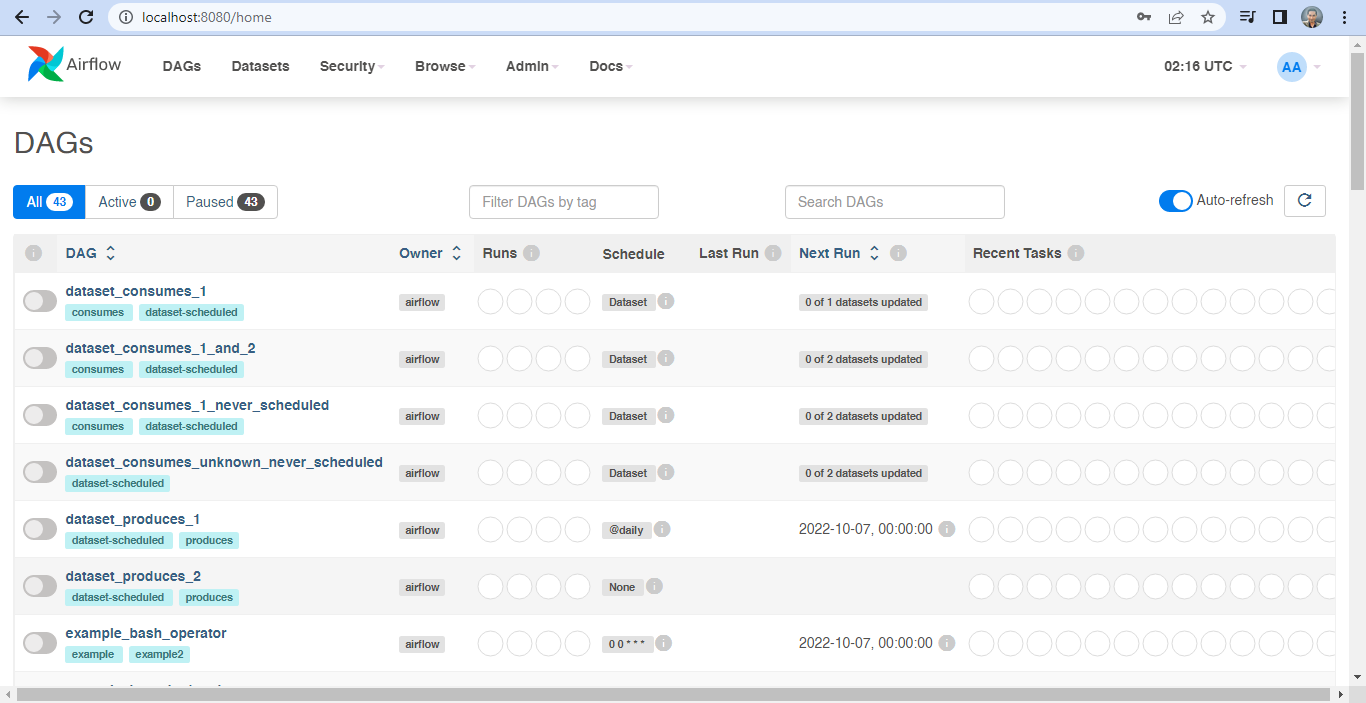

#### Sending requests to the REST API

```
ENDPOINT_URL="http://localhost:8080/"
curl -X GET  \
    --user "airflow:airflow" \
    "${ENDPOINT_URL}/api/v1/pools"
```



#### Cleaning-up the environment



```
docker-compose down --volumes --remove-orphans
```



## Installing from PyPI

Apache Airflow is available as ***apache-airflow*** package in PyPI. Installing it however might be sometimes tricky because Airflow is a bit of both a library and application. Libraries usually keep their dependencies open, and applications usually pin them, but we should do neither and both simultaneously. We decided to keep our dependencies as open as possible (in ***setup.py***) so users can install different versions of libraries if needed. This means that ***pip install apache-airflow*** will not work from time to time or will produce unusable Airflow installation.

To have repeatable installation, however, we keep a set of "known-to-be-working" constraint files in the orphan ***constraints-main*** and ***constraints-2-0*** branches. We keep those "known-to-be-working" constraints files separately per major/minor Python version. You can use them as constraint files when installing Airflow from PyPI. Note that you have to specify correct Airflow tag/version/branch and Python versions in the URL.

1. Installing just Airflow:
Note: Only pip installation is currently officially supported.

While it is possible to install Airflow with tools like Poetry or pip-tools, they do not share the same workflow as pip - especially when it comes to constraint vs. requirements management. Installing via Poetry or pip-tools is not currently supported.

If you wish to install Airflow using those tools, you should use the constraint files and convert them to the appropriate format and workflow that your tool requires.



```
pip install 'apache-airflow==2.3.3' \
 --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-2.3.3/constraints-3.7.txt"
 ```



2. Installing with extras (i.e., postgres, google)




```
pip install 'apache-airflow[postgres,google]==2.3.3' \
 --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-2.3.3/constraints-3.7.txt"
 ```



The installation of Airflow is painless if you are following the instructions below. Airflow uses constraint files to enable reproducible installation, so using pip and constraint files is recommended.



```
# Airflow needs a home. `~/airflow` is the default, but you can put it
# somewhere else if you prefer (optional)
export AIRFLOW_HOME=~/airflow

# Install Airflow using the constraints file
AIRFLOW_VERSION=2.4.1
PYTHON_VERSION="$(python --version | cut -d " " -f 2 | cut -d "." -f 1-2)"
# For example: 3.7
CONSTRAINT_URL="https://raw.githubusercontent.com/apache/airflow/constraints-${AIRFLOW_VERSION}/constraints-${PYTHON_VERSION}.txt"
# For example: https://raw.githubusercontent.com/apache/airflow/constraints-2.4.1/constraints-3.7.txt
pip install "apache-airflow==${AIRFLOW_VERSION}" --constraint "${CONSTRAINT_URL}"

# The Standalone command will initialise the database, make a user,
# and start all components for you.
airflow standalone

# Visit localhost:8080 in the browser and use the admin account details
# shown on the terminal to login.
# Enable the example_bash_operator dag in the home page
```



Upon running these commands, Airflow will create the ```$AIRFLOW_HOME```
folder and create the “airflow.cfg” file with defaults that will get you going fast. You can inspect the file either in ```$AIRFLOW_HOME/airflow.cfg```, or through the UI in the ***Admin->Configuration*** menu.

Out of the box, Airflow uses a SQLite database, which you should outgrow fairly quickly since no parallelization is possible using this database backend. It works in conjunction with the ***SequentialExecutor*** which will only run task instances sequentially. While this is very limiting, it allows you to get up and running quickly and take a tour of the UI and the command line utilities.

As you grow and deploy Airflow to production, you will also want to move away from the ```standalone``` command we use here to running the components separately.


Here are a few commands that will trigger a few task instances. You should be able to see the status of the jobs change in the example_bash_operator DAG as you run the commands below.


```
# run your first task instance
airflow tasks run example_bash_operator runme_0 2015-01-01
# run a backfill over 2 days
airflow dags backfill example_bash_operator \
    --start-date 2015-01-01 \
    --end-date 2015-01-02
```



If you want to run the individual parts of Airflow manually rather than using the all-in-one ```standalone``` command, you can instead run:



```
airflow db init

airflow users create \
    --username admin \
    --firstname Peter \
    --lastname Parker \
    --role Admin \
    --email spiderman@superhero.org

airflow webserver --port 8080

airflow scheduler
```





## Installing from Helm Chart

This chart will bootstrap an Airflow deployment on a Kubernetes cluster using the Helm package manager.



Requirements
- Kubernetes 1.20+ cluster
- Helm 3.0+
- PV provisioner support in the underlying infrastructure (optionally)

Features

- Supported executors: ```LocalExecutor```, ```CeleryExecutor```, ```CeleryKubernetesExecutor```, ```KubernetesExecutor```.
- Supported Airflow version: ```1.10+```, ```2.0+```
- Supported database backend: ```PostgresSQL```, ```MySQL```
- Autoscaling for ```CeleryExecutor``` provided by KEDA
- PostgreSQL and PgBouncer with a battle-tested configuration
- Monitoring:

 - StatsD/Prometheus metrics for Airflow
 - Prometheus metrics for PgBouncer
 - Flower
- Automatic database migration after a new deployment
- Administrator account creation during deployment
- Kerberos secure configuration
- One-command deployment for any type of executor. You don’t need to provide other services e.g. Redis/Database to test the Airflow.

### Installing the Chart



```
helm repo add apache-airflow https://airflow.apache.org
helm upgrade --install airflow apache-airflow/airflow --namespace airflow --create-namespace
```



### Uninstalling the Chart



```
helm delete airflow --namespace airflow
```





---


If you made it this far, follow [David Regalado](https://beacons.ai/davidregalado) for more code!